In [126]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np

In [127]:
# this function will filter an roi using a set of weights
def filter_and_plot(weights,roi):
    # these two lines are important as they ensure correct
    # computations!
    weights = weights.astype(np.float64)
    roi = roi.astype(np.float64)
    # this holds the end result
    filtered = np.zeros_like(roi)
    width = int((weights.shape[1]-1)/2)
    height = int((weights.shape[0]-1)/2)
    # do the filtering
    for i in range(height,roi.shape[1]-height):
        for j in range(width,roi.shape[0]-width):
            sum=0.0
            for k in range(len(weights[1])):
                for p in range(len(weights[0])):
                    sum += roi[j-height+k, i-width+p] * weights[k, p]
            filtered[j ,i] = sum/(len(weights[1]) * len(weights[0]))
    # plot the original, the filter, and the filtered image
    plt.figure(None, figsize=(14, 6))
    grid = plt.GridSpec(1, 7, wspace=0.4, hspace=0.3)
    plt.subplot(grid[0, 0:3])
    plt.imshow(roi,cmap='gray')
    plt.subplot(grid[0, 3])
    extent = (0, weights.shape[1], weights.shape[0], 0)
    plt.imshow(weights,cmap='gray',extent=extent)
    plt.axis('off')
    if width<5:
        for i in range(0,len(weights)):
            for j in range(0,len(weights)):
                if weights[i,j]>0.5*np.max(weights):
                    plt.text(j+0.1,i+0.6,'{0:.2f}'.format(weights[i,j]),color='black')
                else:
                    plt.text(j+0.1,i+0.6,'{0:.2f}'.format(weights[i,j]),color='white')
    plt.grid(True)
    plt.subplot(grid[0, 4:])
    plt.imshow(filtered,cmap='gray')
    plt.show()
    return filtered

### Read Image

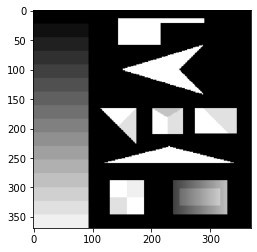

In [128]:
image = plt.imread('./img74.gif')
plt.imshow(image)
plt.show()

### Convert RGB Image to Grayscale image

In [129]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray
gray_image = rgb2gray(image)

### Implement sobel filter operation & Define Ix, Iy

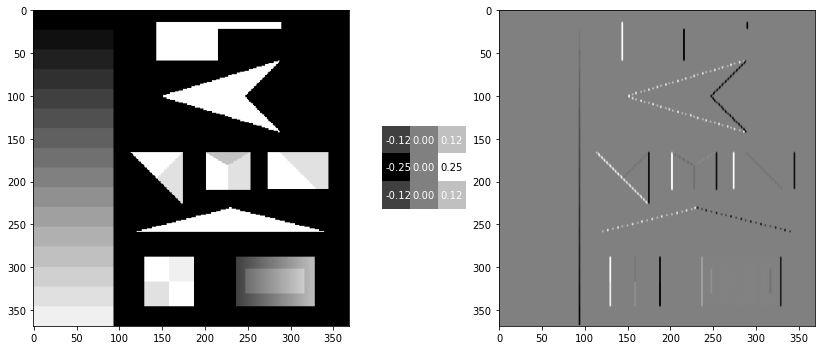

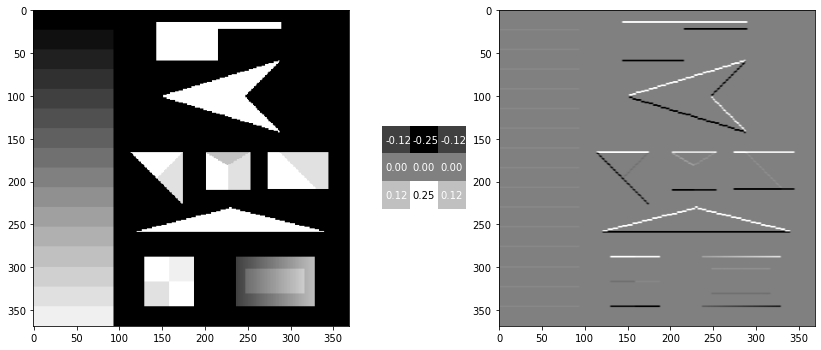

In [130]:
filter_sobelx = np.array([
[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]
])
Ix=filter_and_plot(1/8*filter_sobelx,gray_image)

filter_sobely = np.array([
[-1, -2, -1], [0, 0, 0], [1, 2, 1]
])
Iy=filter_and_plot(1/8*filter_sobely,gray_image)


### Define the E(u,v), width, height

In [131]:
IxIx = Ix * Ix
IxIy = Ix * Iy
IyIy = Iy * Iy

width = gray_image.shape[1]
height = gray_image.shape[0]

### Define the function of conerDetect

In [132]:
winSizes = [3, 5, 7, 9, 11, 15, 21]
threshold = 0.00001
# img is gray scale image
# winsize if total size of window for summation in pixels
# if type is 0, that's eigenvalue version
# elif type is 1, that's Harris version
def cornerDetect(img, winSize=7, type=0):
    time_Sum=0.0
    # Define the value list
    value_list = []
    half = int((winSize - 1) / 2)
    # Calculate H Matrix
    for i in range(half, height - half):
        for j in range(half, width - half):
            A_matrix = IxIx[i - half : i + half+1, j - half : j + half + 1]
            B_matrix = IxIy[i - half : i + half+1, j - half : j + half + 1]
            C_matrix = IyIy[i - half : i + half+1, j - half : j + half + 1]
            A=0.0
            B=0.0
            C=0.0
            
            # Sum of region's value
            for k in range(winSize):
                for l in range(winSize):
                    A += A_matrix[k, l]
                    B += B_matrix[k, l]
                    C += C_matrix[k, l]
            # Define H matrix
            H = np.array([[A, B], [B, C]])
            
            # If eigenvalue version
            if type == 0:
                start = time.time()
                # Define the min, max of lambda
                L_min = (A + C) - np.sqrt(4*B*B + ((A - C) ** 2))
                L_max = (A + C) + np.sqrt(4*B*B + ((A - C) ** 2))
                
                if L_min > threshold:
                    value_list.append([i, j, L_min])
                spent_Time = time.time() - start
                time_Sum += spent_Time
                    
            # Harris simple method version
            else:
                start = time.time()
                # Define the h
                h = (A*C - (B*B)) / (A + C)
                if h > threshold:
                    value_list.append([i, j, h])
                spent_Time = time.time() - start
                time_Sum += spent_Time
    return value_list, time_Sum

### Corner Detection & save the result value

In [133]:
# Define the list of eigenvalue
corner_Eigenvalues = []
corner_Eigenvalues_Time = []

# Define the list of Harris
corner_Harrises = []
corner_Harrises_Time = []

# Corner Detection Time!
for i in range(len(winSizes)):
    corner_Eigenvalue, corner_Eigenvalue_Time = cornerDetect(gray_image, winSizes[i], 0)
    corner_Harris, corner_Harris_Time = cornerDetect(gray_image, winSizes[i], 1)
    
    # Save the results of eigenvalues
    corner_Eigenvalues.append(corner_Eigenvalue)
    corner_Eigenvalues_Time.append(corner_Eigenvalue_Time)
    
    # Save the results of Harris
    corner_Harrises.append(corner_Harris)
    corner_Harrises_Time.append(corner_Harris_Time)

<ipython-input-132-c6fea0c809a6>:47: RuntimeWarning: invalid value encountered in double_scalars
  h = (A*C - (B*B)) / (A + C)


### Eigenvalues drawing

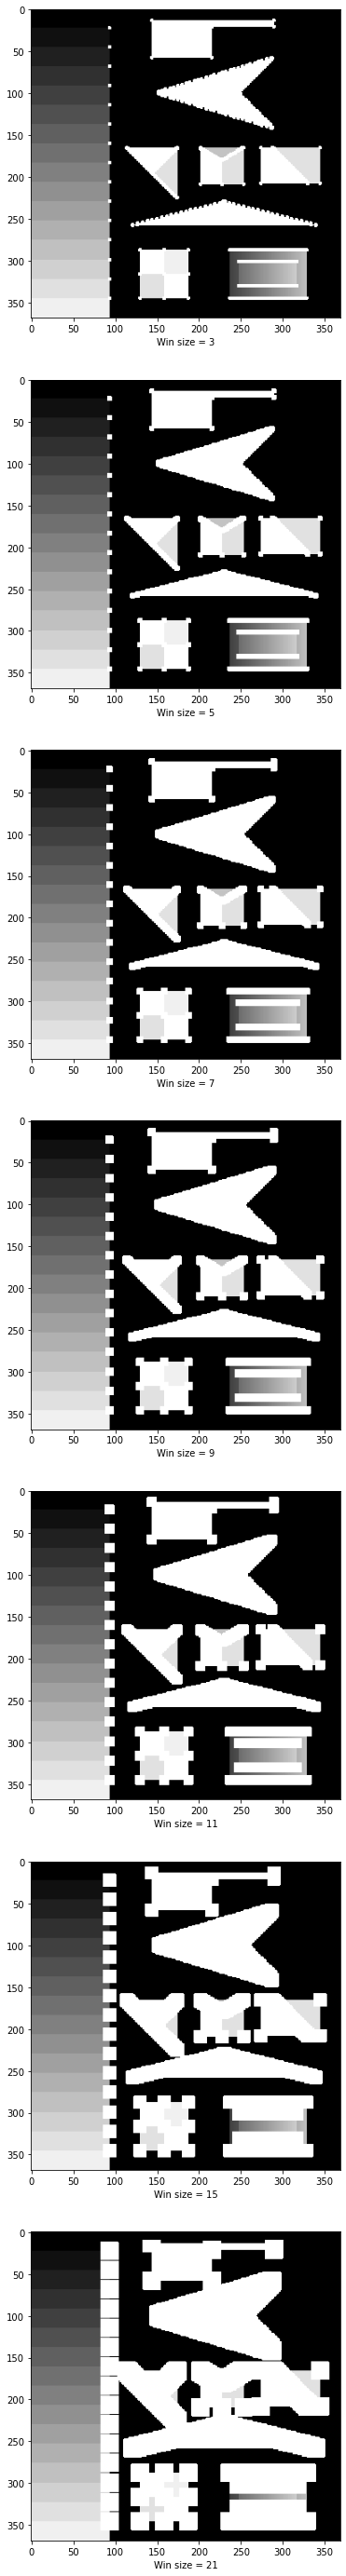

In [134]:
# Define plt property
fig = plt.figure(figsize = (50,50))

# Eigenvalues will be drawed
for i in range(len(winSizes)):
    clone = gray_image.copy()
    ax = fig.add_subplot(len(winSizes), 1, i+1)
    corner_Eigenvalue = corner_Eigenvalues[i]
    for j in range(len(corner_Eigenvalue)):
        clone[corner_Eigenvalue[j][0], corner_Eigenvalue[j][1]] = 255
    ax.imshow(clone, cmap = 'gray')
    ax.set_xlabel("Win size = " + str(winSizes[i]))
plt.show()


### Harris value drawing

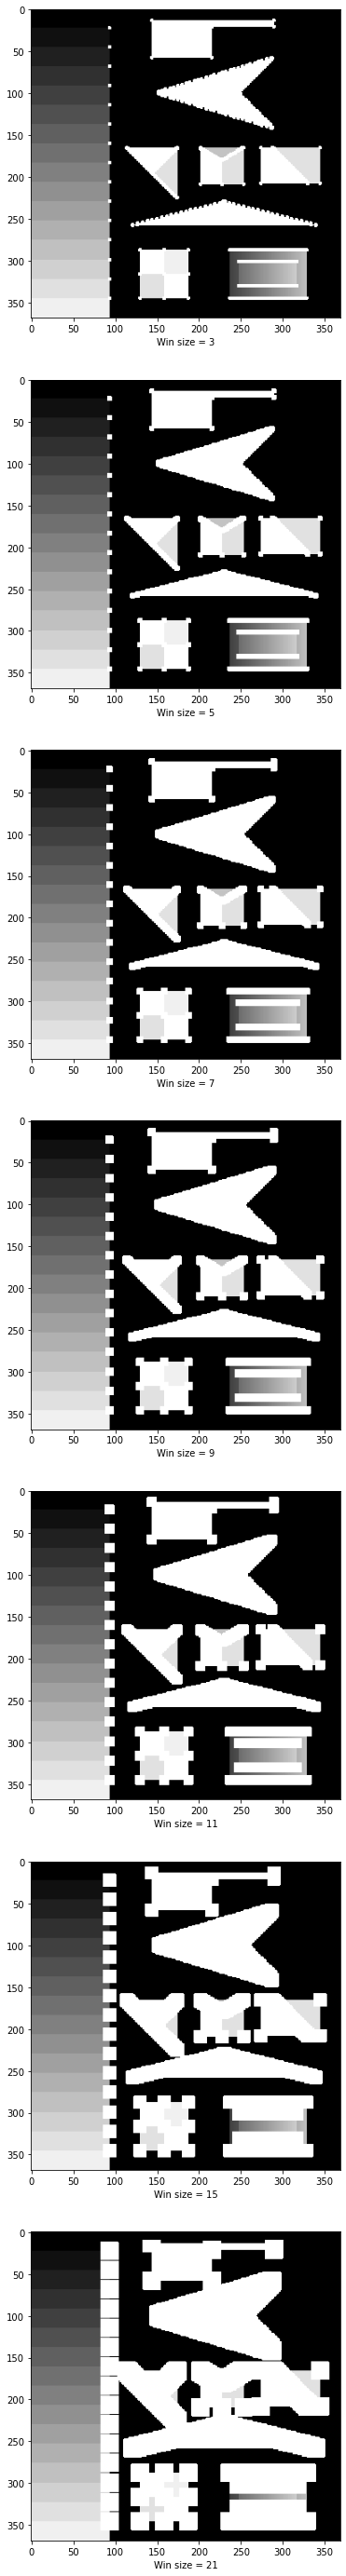

In [135]:
# Define plt property
fig2 = plt.figure(figsize = (50,50))

# Harrises will be drawed
for i in range(len(winSizes)):
    clone = gray_image.copy()
    ax = fig2.add_subplot(len(winSizes), 1, i+1)
    corner_Harris = corner_Harrises[i]
    for j in range(len(corner_Harris)):
        clone[corner_Harris[j][0], corner_Harris[j][1]] = 255
    ax.imshow(clone, cmap = 'gray')
    ax.set_xlabel("Win size = " + str(winSizes[i]))
plt.show()

### Plot the time between Eigenvalues and Harris

Eigenvalues method's spent time is
[0.60504651 0.58699012 0.62302732 0.67904282 0.66145134 0.73718309
 0.6511519 ]
Harris simpler method's spent time is
[0.18712616 0.17290211 0.17325401 0.23768568 0.1815865  0.17521644
 0.14765763]
The time difference is
[3.23336145 3.3949275  3.59603402 2.85689409 3.6426239  4.20727136
 4.4098763 ]
The average time difference is
3.620141230557728


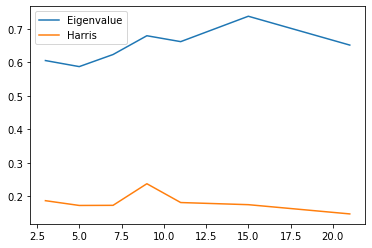

In [136]:
# Plot the spent time of Each methods
x = np.array(winSizes)
corner_Eigenvalues_Time = np.array(corner_Eigenvalues_Time)
corner_Harrises_Time = np.array(corner_Harrises_Time)
print("Eigenvalues method's spent time is")
print(corner_Eigenvalues_Time)
print("Harris simpler method's spent time is")
print(corner_Harrises_Time)
time_Difference = corner_Eigenvalues_Time / corner_Harrises_Time
average_Time_Difference = 0.0
for i in range(len(time_Difference)):
    average_Time_Difference += time_Difference[i]
average_Time_Difference /= len(time_Difference)
print("The time difference is")
print(corner_Eigenvalues_Time / corner_Harrises_Time)
print("The average time difference is")
print(average_Time_Difference)
plt.plot(x, corner_Eigenvalues_Time, label='Eigenvalue')
plt.plot(x, corner_Harrises_Time, label='Harris')
plt.legend()
plt.show()

## Questions ##

1) At which window sizes can you detect all “meaningful” corners?
  -> All of them have meaningfull corners but that is much nicer to see when window size is 3, 5, 7, 9, 11

2) Which method is faster – Eigenvalue or Harris? By how much?
  -> Harris simpler method is more faster about 3.45x than Eigenvalue method

## Bonus Problem

### Load the color image and show

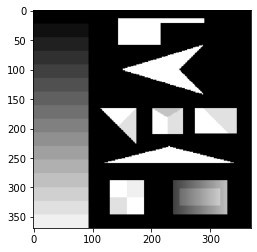

In [137]:
colorImage = plt.imread('./colorimage.png')
plt.imshow(image)
plt.show()

### Define the cornerDetectColor Function

In [138]:
def cornerDetectColor(img, IxIx, IxIy, IyIy, winSize=7, type=0):
    # Define the value list
    value_list = []
    half = int((winSize - 1) / 2)
    # Calculate H Matrix
    for i in range(half, height - half):
        for j in range(half, width - half):
            A_matrix = IxIx[i - half : i + half+1, j - half : j + half + 1]
            B_matrix = IxIy[i - half : i + half+1, j - half : j + half + 1]
            C_matrix = IyIy[i - half : i + half+1, j - half : j + half + 1]
            A=0.0
            B=0.0
            C=0.0
            
            # Sum of region's value
            for k in range(winSize):
                for l in range(winSize):
                    A += A_matrix[k, l]
                    B += B_matrix[k, l]
                    C += C_matrix[k, l]
            # Define H matrix
            H = np.array([[A, B], [B, C]])
            
            # If eigenvalue version
            if type == 0:
                # Define the min, max of lambda
                L_min = (A + C) - np.sqrt(4*B*B + ((A - C) ** 2))
                L_max = (A + C) + np.sqrt(4*B*B + ((A - C) ** 2))
                value_list.append([i, j, L_min])
                    
            # Harris simple method version
            else:
                # Define the h
                h = (A*C - (B*B)) / (A + C)
                value_list.append([i, j, h])
    return value_list

### Define the E(u,v) for each channel

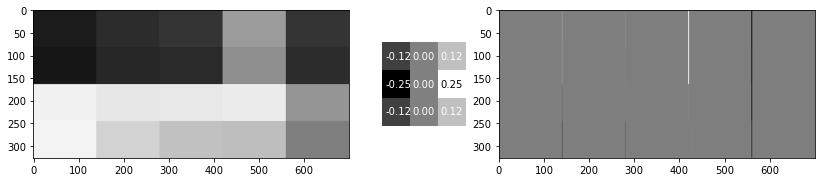

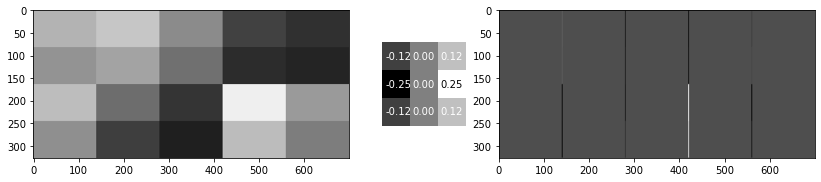

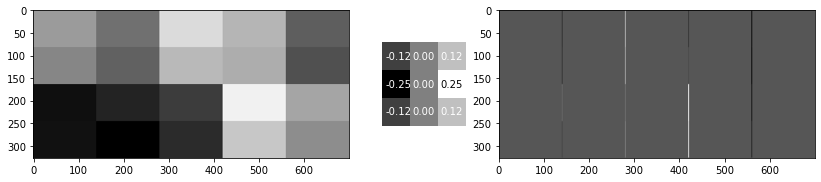

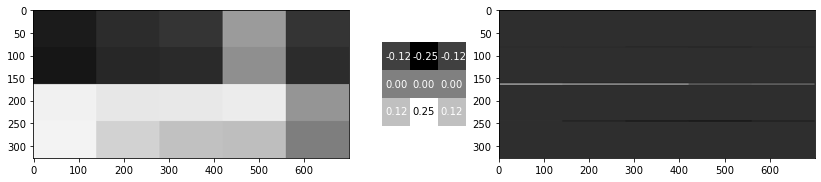

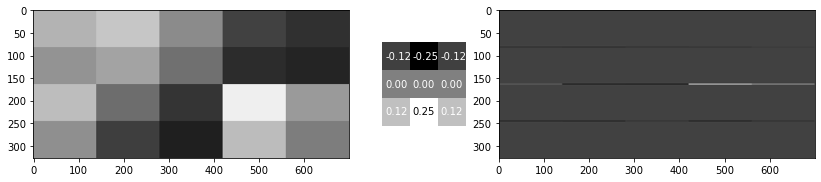

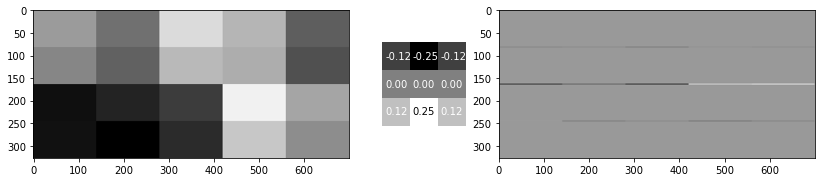

In [139]:
# Operate at each channel (R, G, B)
# Define Ix, Iy
Ix_R = filter_and_plot(1/8*filter_sobelx,colorImage[:,:,0])
Ix_G = filter_and_plot(1/8*filter_sobelx,colorImage[:,:,1])
Ix_B = filter_and_plot(1/8*filter_sobelx,colorImage[:,:,2])

Iy_R = filter_and_plot(1/8*filter_sobely,colorImage[:,:,0])
Iy_G = filter_and_plot(1/8*filter_sobely,colorImage[:,:,1])
Iy_B = filter_and_plot(1/8*filter_sobely,colorImage[:,:,2])

# Define the E(u,v)
IxIx_R = Ix_R * Ix_R
IxIx_G = Ix_G * Ix_G
IxIx_B = Ix_B * Ix_B

IxIy_R = Ix_R * Iy_R
IxIy_G = Ix_G * Iy_G
IxIy_B = Ix_B * Iy_B

IyIy_R = Iy_R * Iy_R
IyIy_G = Iy_G * Iy_G
IyIy_B = Iy_B * Iy_B

### Corner Detection in colorImage and filter out the value less than threshold

In [140]:
width = colorImage.shape[1]
height = colorImage.shape[0]

# Define the list of eigenvalue
corner_Eigenvalues2 = []

# Define the list of Harris
corner_Harrises2 = []

# Corner Detection Time!
for i in range(len(winSizes)):
    corner_Eigenvalue_R = cornerDetectColor(colorImage[:,:,0], IxIx_R, IxIy_R, IyIy_R, winSizes[i], 0)
    corner_Eigenvalue_G = cornerDetectColor(colorImage[:,:,1], IxIx_G, IxIy_G, IyIy_G, winSizes[i], 0)
    corner_Eigenvalue_B = cornerDetectColor(colorImage[:,:,2], IxIx_B, IxIy_B, IyIy_B, winSizes[i], 0)
    corner_Harris_R = cornerDetectColor(colorImage[:,:,0], IxIx_R, IxIy_R, IyIy_R, winSizes[i], 1)
    corner_Harris_G = cornerDetectColor(colorImage[:,:,1], IxIx_G, IxIy_G, IyIy_G, winSizes[i], 1)
    corner_Harris_B = cornerDetectColor(colorImage[:,:,2], IxIx_B, IxIy_B, IyIy_B, winSizes[i], 1)
    
    corner_Eigenvalue=[]
    corner_Harris=[]
    for j in range(len(corner_Eigenvalue_R)):     
        Eigenvalue = (corner_Eigenvalue_R[j][2] + corner_Eigenvalue_G[j][2] + corner_Eigenvalue_B[j][2]) / 3.0
        Harris = (corner_Harris_R[j][2] + corner_Harris_G[j][2] + corner_Harris_B[j][2]) / 3.0
        if Eigenvalue > threshold:
            corner_Eigenvalue.append([corner_Eigenvalue_R[j][0], corner_Eigenvalue_R[j][1], Eigenvalue])
        if Harris > 0.001:
            corner_Harris.append([corner_Harris_R[j][0], corner_Harris_R[j][1], Harris])

    # Save the results of eigenvalues
    corner_Eigenvalues2.append(corner_Eigenvalue)

    # Save the results of Harris
    corner_Harrises2.append(corner_Harris)

<ipython-input-138-6cb5b7931dd3>:34: RuntimeWarning: invalid value encountered in double_scalars
  h = (A*C - (B*B)) / (A + C)


### Eigenvalue drawing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[79, 281, 1.0302340069357085e-05], [80, 138, 8.180012173858377e-05], [80, 139, 8.244203004827471e-05], [80, 140, 7.14694512318961e-05], [80, 141, 6.202294280073722e-05], [80, 277, 1.0778289215435412e-05], [80, 278, 0.00014128314865417956], [80, 279, 0.00013960110234710325], [80, 280, 0.00017473134508109797], [80, 281, 0.0002224050440888058], [80, 282, 1.1729302848053466e-05], [80, 417, 1.1938099680514671e-05], [80, 418, 0.00017368344624353396], [80, 419, 0.0001408290882399211], [80, 420, 8.62709031711055e-05], [80, 421, 7.187620559750446e-05], [80, 422, 1.3683024283355848e-05], [80, 557, 1.6267915919953795e-05], [80, 558, 3.696371690404177e-05], [80, 559, 3.3335341278582975e-05], [80, 560, 2.8308666322074045e-05], [80, 561, 3.4079677546030264e-05], [80, 562, 1.1675675657667301e-05], [81, 138, 8.124057553202601e-05], [81, 139, 6.315708990205603e-05], [81, 140, 5.023888153128186e-05], [81, 141, 6.531565655412061e-05], [81, 278, 0.00014563066280746123], [81, 279, 0.00011221886530833208],

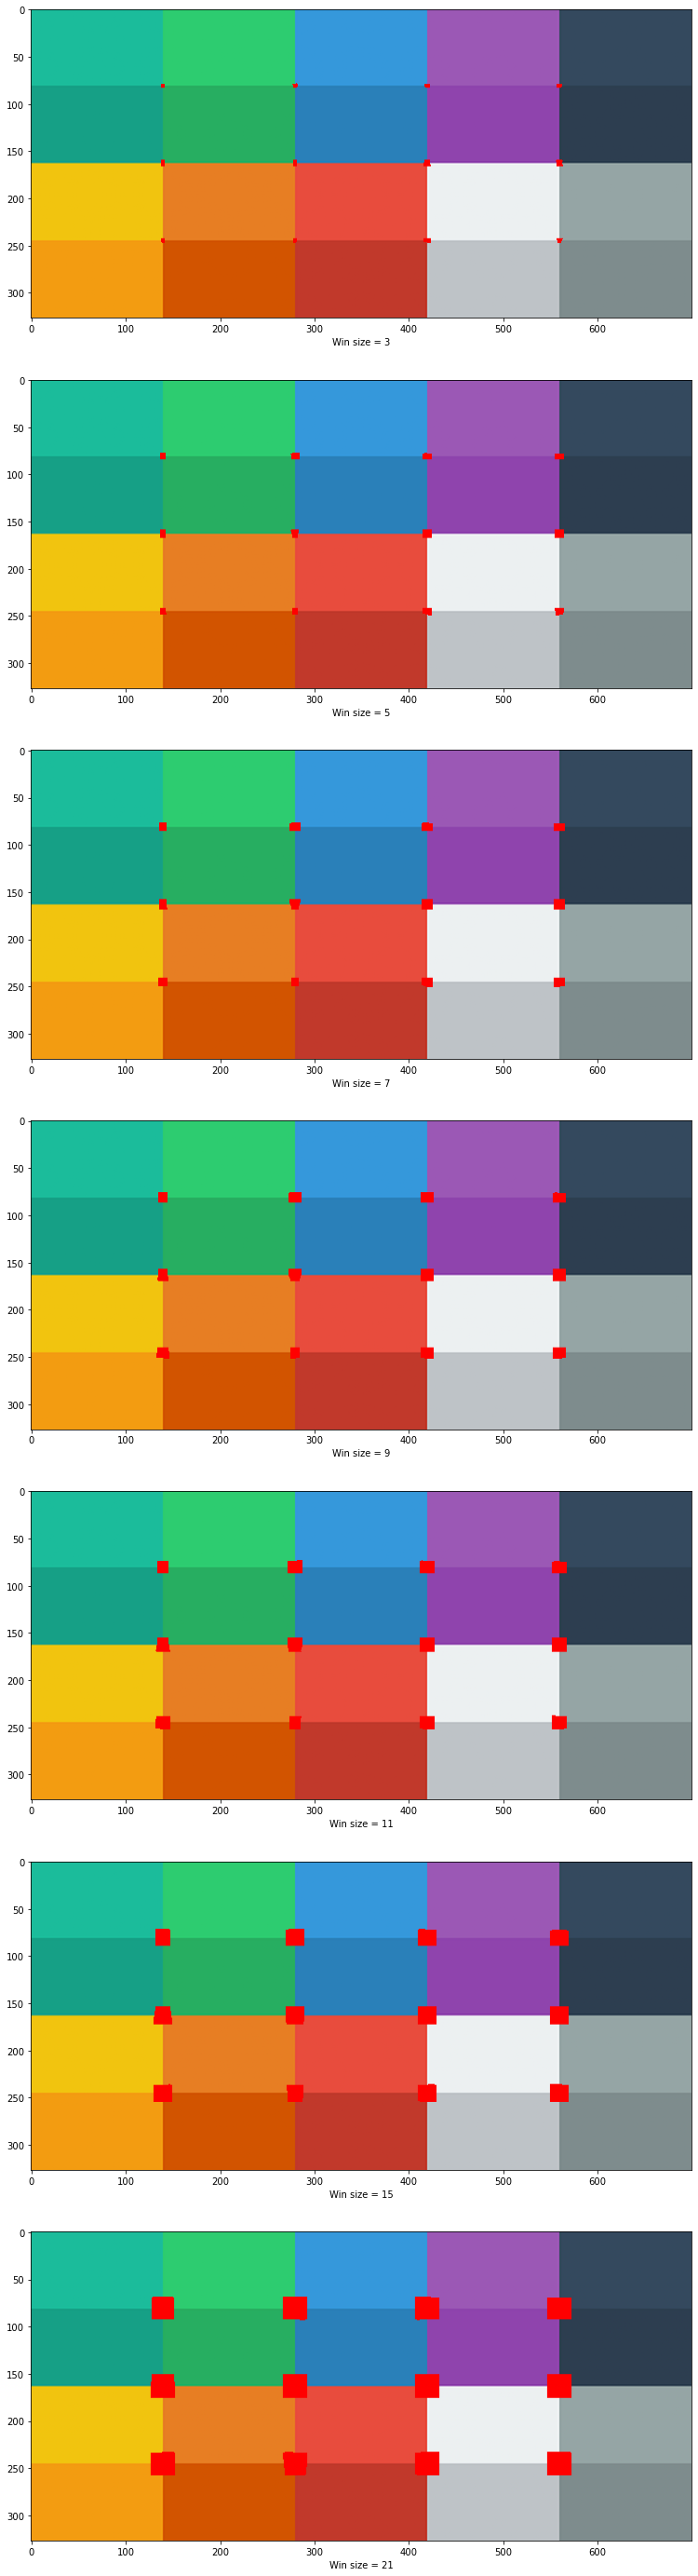

In [141]:
print(corner_Eigenvalues2[0])
# Define plt property
fig = plt.figure(figsize = (50,50))

# Eigenvalues will be drawed
for i in range(len(winSizes)):
    clone = colorImage.copy()
    ax = fig.add_subplot(len(winSizes), 1, i+1)
    temp_Corner_Eigenvalue = corner_Eigenvalues2[i]
    for j in range(len(temp_Corner_Eigenvalue)):
        clone[temp_Corner_Eigenvalue[j][0], temp_Corner_Eigenvalue[j][1], 0] = 255
        clone[temp_Corner_Eigenvalue[j][0], temp_Corner_Eigenvalue[j][1], 1] = 0
        clone[temp_Corner_Eigenvalue[j][0], temp_Corner_Eigenvalue[j][1], 2] = 0
    ax.imshow(clone)
    ax.set_xlabel("Win size = " + str(winSizes[i]))
plt.show()

### Harris drawing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


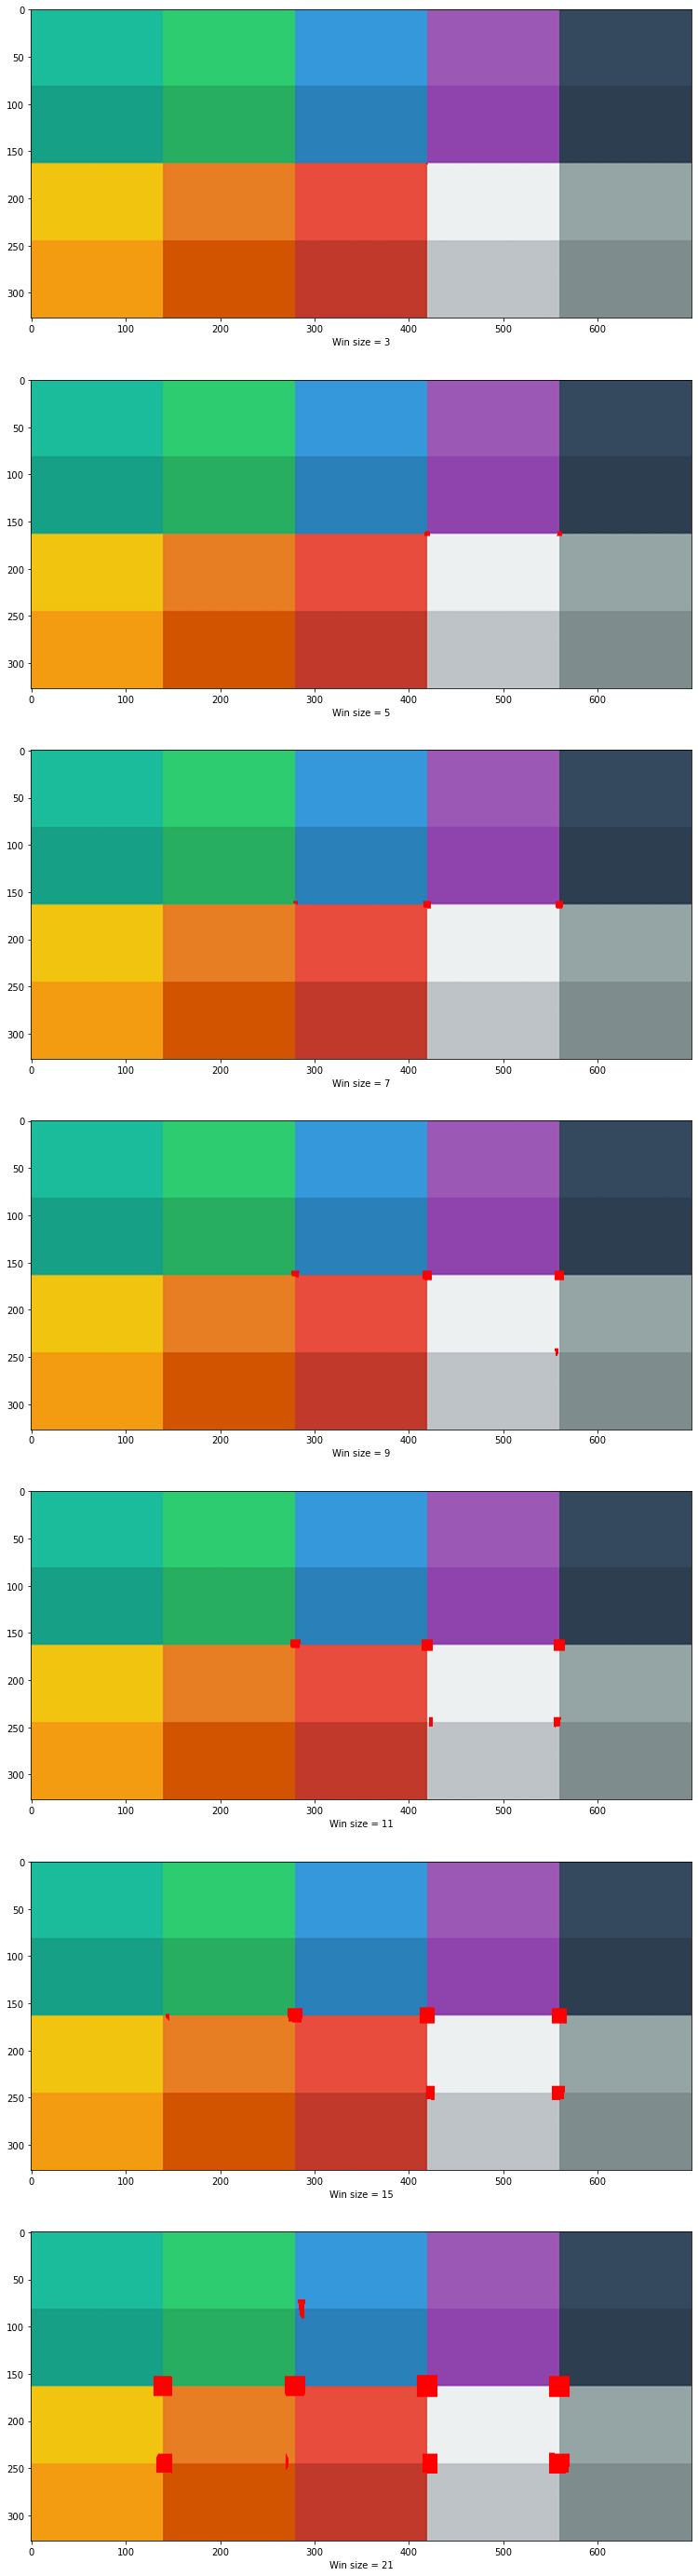

In [142]:
# Define plt property
fig2 = plt.figure(figsize = (50,50))

# Harrises will be drawed
for i in range(len(winSizes)):
    clone = colorImage.copy()
    ax = fig2.add_subplot(len(winSizes), 1, i+1)
    temp_Corner_Harris = corner_Harrises2[i]
    for j in range(len(temp_Corner_Harris)):
        clone[temp_Corner_Harris[j][0], temp_Corner_Harris[j][1], 0] = 255
        clone[temp_Corner_Harris[j][0], temp_Corner_Harris[j][1], 1] = 0
        clone[temp_Corner_Harris[j][0], temp_Corner_Harris[j][1], 2] = 0
    ax.imshow(clone)
    ax.set_xlabel("Win size = " + str(winSizes[i]))
plt.show()